=== Observational Association P(Diagnosis | Test_Result) ===
P(Diagnosis=Observation | Test_Result=Normal) = 0.937
P(Diagnosis=Further Testing | Test_Result=Normal) = 0.063
P(Diagnosis=Aggressive Treatment | Test_Result=Normal) = 0.000
P(Diagnosis=Standard Treatment | Test_Result=Normal) = 0.000

P(Diagnosis=Observation | Test_Result=Lung Function Reduced) = 0.000
P(Diagnosis=Further Testing | Test_Result=Lung Function Reduced) = 1.000
P(Diagnosis=Aggressive Treatment | Test_Result=Lung Function Reduced) = 0.000
P(Diagnosis=Standard Treatment | Test_Result=Lung Function Reduced) = 0.000

P(Diagnosis=Observation | Test_Result=Inflammatory Markers High) = 0.000
P(Diagnosis=Further Testing | Test_Result=Inflammatory Markers High) = 0.000
P(Diagnosis=Aggressive Treatment | Test_Result=Inflammatory Markers High) = 1.000
P(Diagnosis=Standard Treatment | Test_Result=Inflammatory Markers High) = 0.000

P(Diagnosis=Observation | Test_Result=Positive Flu) = 0.000
P(Diagnosis=Further Testing | Te

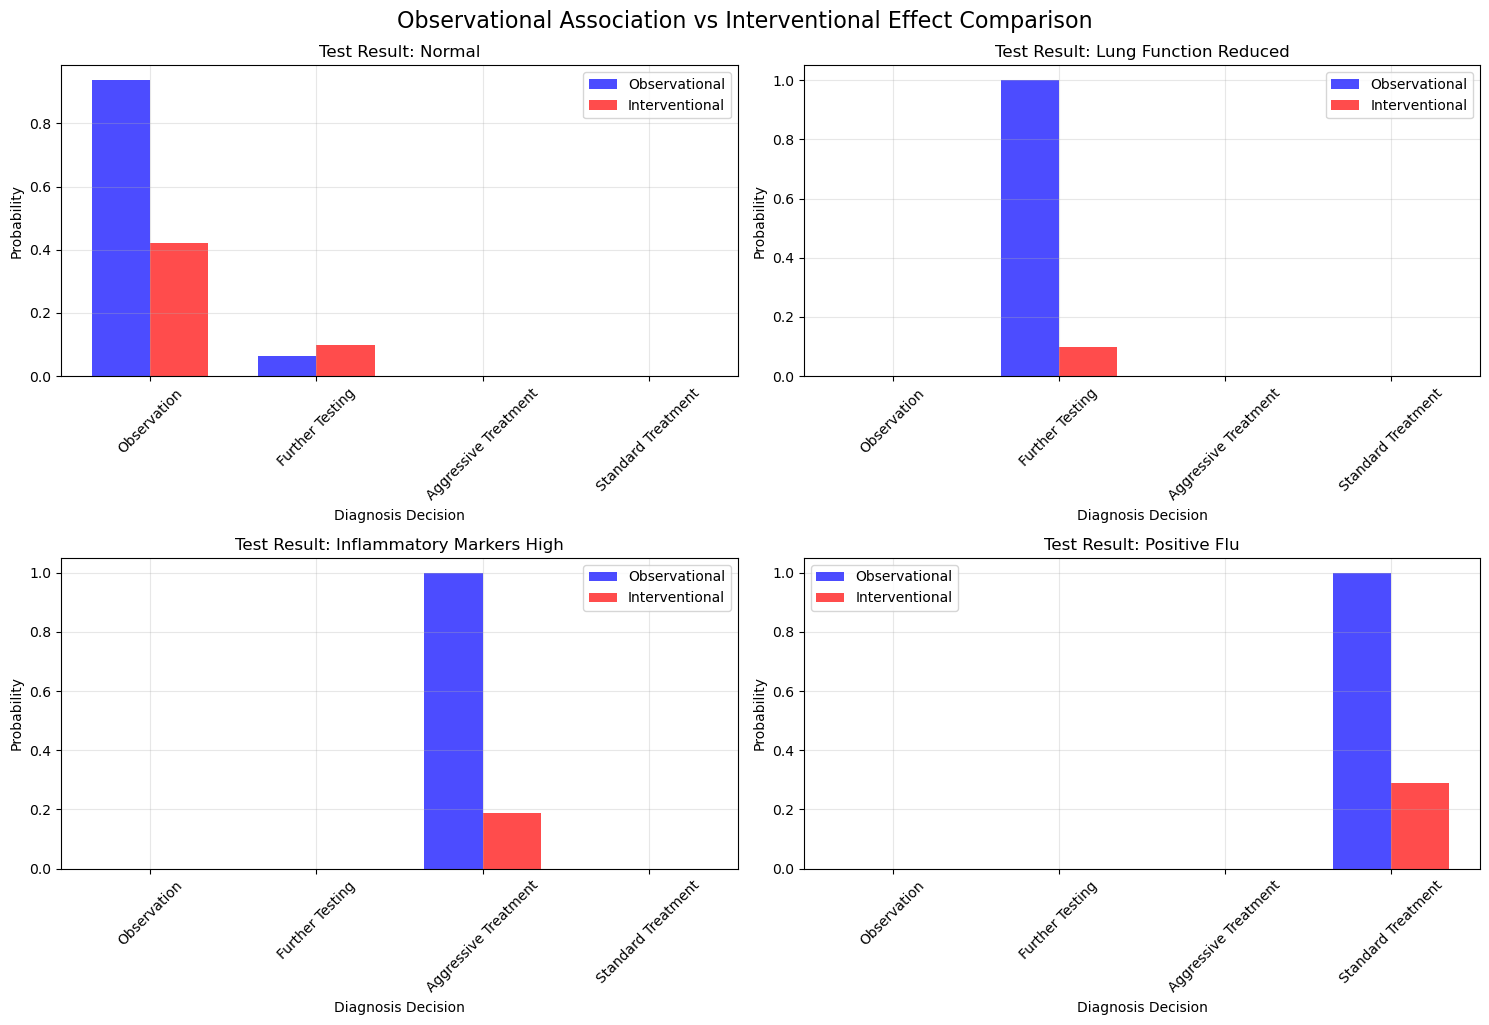


=== Counterfactual Analysis ===
Scenario: Predict changes in diagnosis decisions if testing strategy is changed (intervening on Test_Result)

Counterfactual Analysis: From Normal to Chest X-ray Abnormal
P(Observation) change: 0.421 → 0.000 (Δ = -0.421)
P(Further Testing) change: 0.100 → 0.000 (Δ = -0.100)
P(Aggressive Treatment) change: 0.000 → 0.188 (Δ = +0.188)
P(Standard Treatment) change: 0.000 → 0.000 (Δ = +0.000)

=== Average Treatment Effect (ATE) Analysis ===
Average Treatment Effect for Observation: 0.000
Average Treatment Effect for Further Testing: 0.000
Average Treatment Effect for Aggressive Treatment: -0.000
Average Treatment Effect for Standard Treatment: 0.000

=== Confounding Bias Analysis ===
Comparing observational and interventional differences indicates confounding bias:
Average confounding bias for Normal: 0.138
Average confounding bias for Lung Function Reduced: 0.225
Average confounding bias for Inflammatory Markers High: 0.203
Average confounding bias for Posi

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def compare_observational_interventional(data_path='medical_causal_data.csv'):
    """
    Function to compare observational association P(Y|X) with interventional effect P(Y|do(X))
    
    Input:
    - data_path: path to data file, default 'medical_causal_data.csv'
    
    Output:
    - dict: containing comparison results of observational and interventional probabilities
    
    Functionality:
    - Calculate observational conditional probability P(Diagnosis|Test_Result)
    - Calculate interventional effect P(Diagnosis|do(Test_Result)) using backdoor adjustment
    - Compare differences between two probabilities, demonstrating confounding bias
    - Visualize comparison results
    """
    
    # Read data
    data = pd.read_csv(data_path)
    
    # Encode data for calculation
    le_disease = LabelEncoder()
    le_symptoms = LabelEncoder() 
    le_test = LabelEncoder()
    le_diagnosis = LabelEncoder()
    
    data_encoded = data.copy()
    data_encoded['Disease_encoded'] = le_disease.fit_transform(data['Disease'])
    data_encoded['Symptoms_encoded'] = le_symptoms.fit_transform(data['Symptoms'])
    data_encoded['Test_Result_encoded'] = le_test.fit_transform(data['Test_Result'])
    data_encoded['Diagnosis_encoded'] = le_diagnosis.fit_transform(data['Diagnosis'])
    
    # 1. Calculate observational association P(Diagnosis | Test_Result)
    print("=== Observational Association P(Diagnosis | Test_Result) ===")
    observational_probs = {}
    
    test_categories = data['Test_Result'].unique()
    diagnosis_categories = data['Diagnosis'].unique()
    
    for test_cat in test_categories:
        test_data = data[data['Test_Result'] == test_cat]
        observational_probs[test_cat] = {}
        
        for diag_cat in diagnosis_categories:
            prob = len(test_data[test_data['Diagnosis'] == diag_cat]) / len(test_data)
            observational_probs[test_cat][diag_cat] = prob
            print(f"P(Diagnosis={diag_cat} | Test_Result={test_cat}) = {prob:.3f}")
        print()
    
    # 2. Calculate interventional effect P(Diagnosis | do(Test_Result)) using backdoor adjustment
    print("=== Interventional Effect P(Diagnosis | do(Test_Result)) ===")
    interventional_probs = {}
    
    # Using backdoor adjustment formula: P(Y|do(X)) = Σ_Z P(Y|X,Z)P(Z)
    # where Z is the backdoor variable (Disease D)
    
    for test_cat in test_categories:
        interventional_probs[test_cat] = {}
        
        for diag_cat in diagnosis_categories:
            # Marginalize over Disease D
            total_prob = 0
            for disease_cat in data['Disease'].unique():
                # P(Disease = d)
                p_disease = len(data[data['Disease'] == disease_cat]) / len(data)
                
                # P(Diagnosis = y | Test_Result = x, Disease = d)
                disease_test_data = data[(data['Disease'] == disease_cat) & (data['Test_Result'] == test_cat)]
                if len(disease_test_data) > 0:
                    p_diag_given_test_disease = len(
                        disease_test_data[disease_test_data['Diagnosis'] == diag_cat]
                    ) / len(disease_test_data)
                else:
                    p_diag_given_test_disease = 0
                
                total_prob += p_disease * p_diag_given_test_disease
            
            interventional_probs[test_cat][diag_cat] = total_prob
            print(f"P(Diagnosis={diag_cat} | do(Test_Result={test_cat})) = {total_prob:.3f}")
        print()
    
    # 3. Compare differences between observational association and interventional effect
    print("=== Observational vs Interventional Effect Difference Analysis ===")
    comparison_results = {}
    
    for test_cat in test_categories:
        comparison_results[test_cat] = {}
        print(f"\nTest Result: {test_cat}")
        print("Diagnosis Decision | Observational Prob | Interventional Prob | Difference")
        print("-" * 70)
        
        for diag_cat in diagnosis_categories:
            obs_prob = observational_probs[test_cat][diag_cat]
            int_prob = interventional_probs[test_cat][diag_cat]
            difference = obs_prob - int_prob
            comparison_results[test_cat][diag_cat] = {
                'observational': obs_prob,
                'interventional': int_prob,
                'difference': difference
            }
            print(f"{diag_cat:25} | {obs_prob:.3f}              | {int_prob:.3f}               | {difference:+.3f}")
    
    # 4. Visualization comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, test_cat in enumerate(test_categories[:4]):  # Show first 4 test results
        if idx < len(axes):
            diagnoses = list(diagnosis_categories)
            obs_probs = [observational_probs[test_cat][d] for d in diagnoses]
            int_probs = [interventional_probs[test_cat][d] for d in diagnoses]
            
            x = np.arange(len(diagnoses))
            width = 0.35
            
            axes[idx].bar(x - width/2, obs_probs, width, label='Observational', alpha=0.7, color='blue')
            axes[idx].bar(x + width/2, int_probs, width, label='Interventional', alpha=0.7, color='red')
            
            axes[idx].set_xlabel('Diagnosis Decision')
            axes[idx].set_ylabel('Probability')
            axes[idx].set_title(f'Test Result: {test_cat}')
            axes[idx].set_xticks(x)
            axes[idx].set_xticklabels(diagnoses, rotation=45)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Observational Association vs Interventional Effect Comparison', fontsize=16, y=1.02)
    plt.show()
    
    # 5. Counterfactual analysis example
    print("\n=== Counterfactual Analysis ===")
    print("Scenario: Predict changes in diagnosis decisions if testing strategy is changed (intervening on Test_Result)")
    
    # Analyze specific test result changes
    original_test = 'Normal'
    interventional_test = 'Chest X-ray Abnormal'
    
    print(f"\nCounterfactual Analysis: From {original_test} to {interventional_test}")
    for diag_cat in diagnosis_categories:
        original_prob = interventional_probs[original_test][diag_cat]
        new_prob = interventional_probs[interventional_test][diag_cat]
        change = new_prob - original_prob
        print(f"P({diag_cat}) change: {original_prob:.3f} → {new_prob:.3f} (Δ = {change:+.3f})")
    
    # 6. Calculate Average Treatment Effect (ATE)
    print("\n=== Average Treatment Effect (ATE) Analysis ===")
    for diag_cat in diagnosis_categories:
        ate = 0
        n_comparisons = 0
        
        for test1 in test_categories:
            for test2 in test_categories:
                if test1 != test2:
                    effect = (interventional_probs[test2][diag_cat] - 
                            interventional_probs[test1][diag_cat])
                    ate += effect
                    n_comparisons += 1
        
        if n_comparisons > 0:
            ate /= n_comparisons
            print(f"Average Treatment Effect for {diag_cat}: {ate:.3f}")
    
    # 7. Confounding bias analysis
    print("\n=== Confounding Bias Analysis ===")
    print("Comparing observational and interventional differences indicates confounding bias:")
    
    max_bias_test = None
    max_bias_value = 0
    
    for test_cat in test_categories:
        total_bias = 0
        for diag_cat in diagnosis_categories:
            total_bias += abs(comparison_results[test_cat][diag_cat]['difference'])
        
        avg_bias = total_bias / len(diagnosis_categories)
        print(f"Average confounding bias for {test_cat}: {avg_bias:.3f}")
        
        if avg_bias > max_bias_value:
            max_bias_value = avg_bias
            max_bias_test = test_cat
    
    print(f"\nMaximum confounding bias observed for test result: {max_bias_test} (bias = {max_bias_value:.3f})")
    
    return {
        'observational_probs': observational_probs,
        'interventional_probs': interventional_probs,
        'comparison_results': comparison_results
    }

# Run causal effect comparison
causal_comparison = compare_observational_interventional()